In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [2]:

import cv2
import math

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from matplotlib import colors
from asgiref.sync import sync_to_async #in order to load variables to communicate between sync and async

import optimal_path as op

from robot import Robot
from Map import Map
from Local_navigation import* 
from Mouvement import*
from vision import*
from optimal_path import* 


map_lenght = 1
nb_of_square_by_side = 50
current = 1

global move 
move = False #bool which indicate how our robot is moving (1: avoid an object VS 0: following the optimal path)
kalman_bool = False
old_distance = 0
old_angle = 0
ERR_POS = 3
speed_right = 0
speed_left = 0
#pourcentage_reduc = 1

In [3]:


#VideoCap = vision_initialization()
VideoCap=cv2.VideoCapture(1)


In [4]:
@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500, verbose=False):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    param verbose: whether to print status messages or not
    """
    global motor_left_target, motor_right_target
    # Printing the speeds if requested
    if verbose:
        print("\t\t Setting speed : ", l_speed, r_speed)
    motor_left_target = l_speed
    motor_right_target = r_speed

In [5]:
@tdmclient.notebook.sync_var
def proxi():
    """
    Returns the proximity values of the Thymio 
    """
    global prox_horizontal
    return prox_horizontal


In [7]:
#############################
#Test MASK  A LANCER QUE POUR FAIRE DES TESTS SUR LE MASK
#############################

while True:
    ret, frame = VideoCap.read()
    mask, b = mask_map_init(frame)
    
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        break
    cv2.imshow("mask",mask)
    cv2.imshow("mask B",b)
    #pos_robot, angle = update(frame, 0.5)


KeyboardInterrupt: 

In [6]:
George = Robot()
Lausanne = Map(map_lenght, nb_of_square_by_side)
KF = KalmanFilter(0.1,[0.0,0.0])

taille frame (1080, 1920, 3)
MAP INITIALISATION
first while
searching for the strart pos
goal (27, 36)
start position (71, 12)
PATH COMPUTATION


True

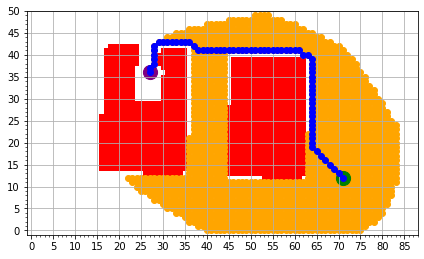

In [7]:
#np.set_printoptions(threshold=sys.maxsize)
####################################
## INIT
####################################
nb_frame_to_take = 10
# Prend une première image
for i in range (nb_frame_to_take): 
    ret, frame = VideoCap.read()
    
print("taille frame", frame.shape)
cv2.imwrite("debut.jpg", frame)

print("MAP INITIALISATION")
# Set the pourcentage value between the nb of pixel and nb of square by side
Lausanne.set_map_lenght(frame)
#print("Pourcentage",Lausanne.get_pourcentage())
# Set the robot goal, position and angle
goal = init_goal(frame, Lausanne.get_pourcentage())
#goal = (50, 40)

# Set pour relancer direct
pos_robot = (-1,-1)
George.set_pos(pos_robot) 
#print("GOAL", goal)

print("first while")
#pos_robot, angle = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....
 
      #Utiliser au cas où il ne trouve pas la bonne position du premier coup
while (pos_robot[0] <= 0) & (pos_robot[1] <= 0):
    #ret, frame=VideoCap.read()
    #display(frame,1,0,0)
    print("searching for the strart pos")
    ret, frame=VideoCap.read()
    #vs.display (frame, 0, 1, 1, 0, 5, Lausanne.get_pourcentage())
    pos_robot, angle, bool_mesure = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....
    #print("Waiting robot position") 

George.set_angle(angle)
George.set_goal(goal)
George.set_start_pos(pos_robot)
George.set_pos(pos_robot)
print ("goal", goal)
print ("start position", pos_robot)

# SET MAP
Lausanne.set_map_lenght(frame)
#print("Lausanna lenght", Lausanne.get_lenght())

# MASK 
mask_bleu, mask_green = mask_map_init(frame)
#cv2.imshow("mask", mask)
cv2.imwrite("masque1.jpg", mask_bleu)
cv2.imwrite("masque2.jpg", mask_green)

# Fin de l'init
Lausanne.init_grid(mask_bleu,mask_green)
grille = Lausanne.get_map()
#cv2.imshow("grid", grille)
cv2.imwrite("grille.jpg", grille)

# OPTIMAL PATH
print("PATH COMPUTATION")
path, visitedNodes = op.path_computation(George.get_start() , George.get_goal() , Lausanne.get_lenght(), grille)

George.set_path(path) 
George.set_visit_nodes(visitedNodes) 

# Display the optimal path
op.display_map(Lausanne.get_lenght(),  grille,  George.get_visit_nodes(), George.get_path(), George.get_start(), George.get_goal())
#print("PATH", George.get_path())

display (frame, 0, 1, 1, 1, George.get_path(), Lausanne.get_pourcentage())
#print("PATH22222", George.get_path())
cv2.imwrite("TOTAL.jpg", frame)

#vision_end(VideoCap)



In [8]:

####################################
## while
####################################

George.set_current(0)
current= 0
kalman_bool = False
print("PATH", George.get_path())
old_distance = 0
old_angle = 0
soon_arrived = False
thresh_indentation = 15
print('START MOUVEMENT')
while True:#(George.get_pos() != George.get_goal()):
    
    # Read the camera
    ret, frame=VideoCap.read()
    
    # Recupere la position et angle --> XAV
    pos_robot,angle_robot, bool_mesure = update(frame, Lausanne.get_pourcentage())
    print("pos avant kalman", pos_robot)
    pos = KF.kalmanFilter(bool_mesure, speed_left, speed_right, pos_robot, angle_robot)
    print("pos après kalman", pos)
    George.set_pos(pos)
    George.set_angle(angle_robot)
    
    if(current < George.get_path().shape[1]-1):
        current = path_update(pos, ERR_POS, np.transpose(George.get_path())[current], George.get_current())
        George.set_current(current)
    else:
        print("READY TO PARK")
        motors(0,0)
        break
    
    #print("pos", pos_robot)
    #print("taille", George.get_path().shape[1])
    #print("current", current)
    pos_goal =  np.transpose(George.get_path())[current]
    
    if current > (George.get_path().shape[1] - thresh_indentation) :
        soon_arrived = True
        print('soon arrived')
    
    proximity = proxi()
    #print ('proximity', proximity)
    move = check_cars(prox_horizonta=proximity)
    #print('move check cars', move)
    
        #LOCAL NAVIGATION
    if move and not (soon_arrived):
        #Thymio is avoiding obstacles
        print("OBSTACLLLEEEE")
        speed_l, speed_r, move = avoid_obstacle(prox_horizonta=proximity) 
    else:
        #Thymio is following the optimal path
        #print("Avancee")
        speed_l, speed_r, old_distance, old_goal  = move_to_position(pos, angle_robot, pos_goal, old_distance, old_angle)
        #Thymio is checking if there's an obstacle in front of it
        move = check_cars(prox_horizonta=proximity)
        print (speed_l, speed_r)
       
    
    speed_right =  speed_r
    speed_left = speed_l
    motors(speed_l, speed_r) 
    
    display (frame, 0, 1, 1, 1, path, Lausanne.get_pourcentage())
    
    # Quit when we press q
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        motors(0,0)
        break
     
    sleep(0.1)

print("PARKING")


"""
proximity = proxi()

while proxis[2] > parking_treshold

    speed0 = 70
    err_angle = proxis[1]-proxis[3]
    err_dist = proxis[2]
    
    speed_l = speed0 + Kp*err_dist + Kp*err_angle
    speed _r = speed0 + Kp*err_dist - Kp*err_angle
    if(err_dist < min_err_dist)
        motors(0,0)
        print("ARRIVED")
        break
    motors(speed_l, speed_r)
    proximity = proxi()
    
"""
    

PATH [[71 70 69 68 67 66 65 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
  64 64 64 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44
  43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 28 28 28 28 27 27]
 [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
  36 37 38 39 40 40 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
  41 41 41 41 41 41 42 43 43 43 43 43 43 43 43 42 41 40 39 38 37 36]]
START MOUVEMENT
pos avant kalman (71, 12)
MESURE
pos après kalman [0. 0.]
-2.8635036539453753
200 -572
pos avant kalman (71, 12)
MESURE
pos après kalman [47.  8.]
-2.771936160716823
200 -554
pos avant kalman (71, 11)
MESURE
pos après kalman [62.4 10.9]
-2.3812299872265617
200 -476
pos avant kalman (71, 10)
MESURE
pos après kalman [68.3 10.8]
next goal plz
-1.260175951317175
200 -156
pos avant kalman (70, 10)
MESURE
pos après kalman [70.2  9.7]
-0.2588544728247708
148 44
pos avant kalman (70, 10)
MESURE
pos après kalman [70. 10.]
-0.19448011621510553
134 

pos avant kalman (64, 23)
pos après kalman [60.5 30. ]
-1.3928367641318389
200 -180
PARKING


'\nproximity = proxi()\n\nwhile proxis[2] > parking_treshold\n\n    speed0 = 70\n    err_angle = proxis[1]-proxis[3]\n    err_dist = proxis[2]\n    \n    speed_l = speed0 + Kp*err_dist + Kp*err_angle\n    speed _r = speed0 + Kp*err_dist - Kp*err_angle\n    if(err_dist < min_err_dist)\n        motors(0,0)\n        print("ARRIVED")\n        break\n    motors(speed_l, speed_r)\n    proximity = proxi()\n    \n'

In [9]:
vision_end(VideoCap)

In [9]:
motors(0,0)